In [5]:
import sys
import math
import datetime
from pathlib import Path

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(str(Path("..").resolve()))
from hyper_rbm import load_model
from wavefunction_overlap import generate_basis_states, calculate_exact_overlap, load_gt_wavefunction

# Define paths
data_dir = Path("measurements")
state_dir = Path("state_vectors")
models_dir = Path("models")
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print(f"Running on: {device}")
print(f"Looking for models in: {models_dir}")

Running on: cpu
Looking for models in: models


In [6]:
def estimate_susceptibility(model, h_val, n_samples, k_steps, rng):
    dtype = next(model.parameters()).dtype

    with torch.no_grad():
        cond_batch_gen = torch.full((n_samples, 1), h_val, device=device, dtype=dtype)

        schedule_tensor = torch.tensor([1.0] * k_steps, device=device, dtype=dtype)
        samples = model.generate(cond_batch_gen, T_schedule=schedule_tensor, rng=rng)

    # create a batch of conditioning values for later gradient computation
    cond_batch_grad = torch.full((n_samples, 1), h_val, device=device, dtype=dtype, requires_grad=True)

    # we evaluate log_score with gradients enabled on cond_batch
    log_psi = model.log_score(samples, cond_batch_grad)

    # since we parametrized log_psi with cond_batch the Jacobian has only main diagonal terms
    grads = torch.autograd.grad(
        outputs=log_psi,
        inputs=cond_batch_grad,
        grad_outputs=torch.ones_like(log_psi), # upstream gradient in VJP (scales each main diag term)
        create_graph=False
    )[0]

    # quadratic formula can be simplified to variance of the gradient (Var(d log_psi / dh))
    chi = torch.var(grads.squeeze(), unbiased=True)
    return chi.item()

In [7]:
model_filename = "hyprbm_tfim_3x3_10000_suscept_20260121_200829.pt"
model_path = models_dir / model_filename

print(f"Loading checkpoint: {model_path.name}")

model, config = load_model(model_path, device)

h_support = config.get("h_support", [])
SIDE_LENGTH = int(math.sqrt(model.num_v))

print(f"Trained on support points: {h_support} \n")

ref_file = Path(f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_suscept_ref.csv")
ref_df = pd.read_csv(ref_file)
print(f"Loaded ED reference data from: {ref_file.name}")

Loading checkpoint: hyprbm_tfim_3x3_10000_suscept_20260121_200829.pt
Trained on support points: [1.0, 1.4, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5] 

Loaded ED reference data from: tfim_3x3_suscept_ref.csv


Sweeping from h=1.0 to h=4.5 in 50 steps with 100000 Gibbs samples each...
h=1.64 | chi=0.2662
h=2.36 | chi=0.2971
h=3.07 | chi=0.1331
h=3.79 | chi=0.0304
h=4.50 | chi=0.0065


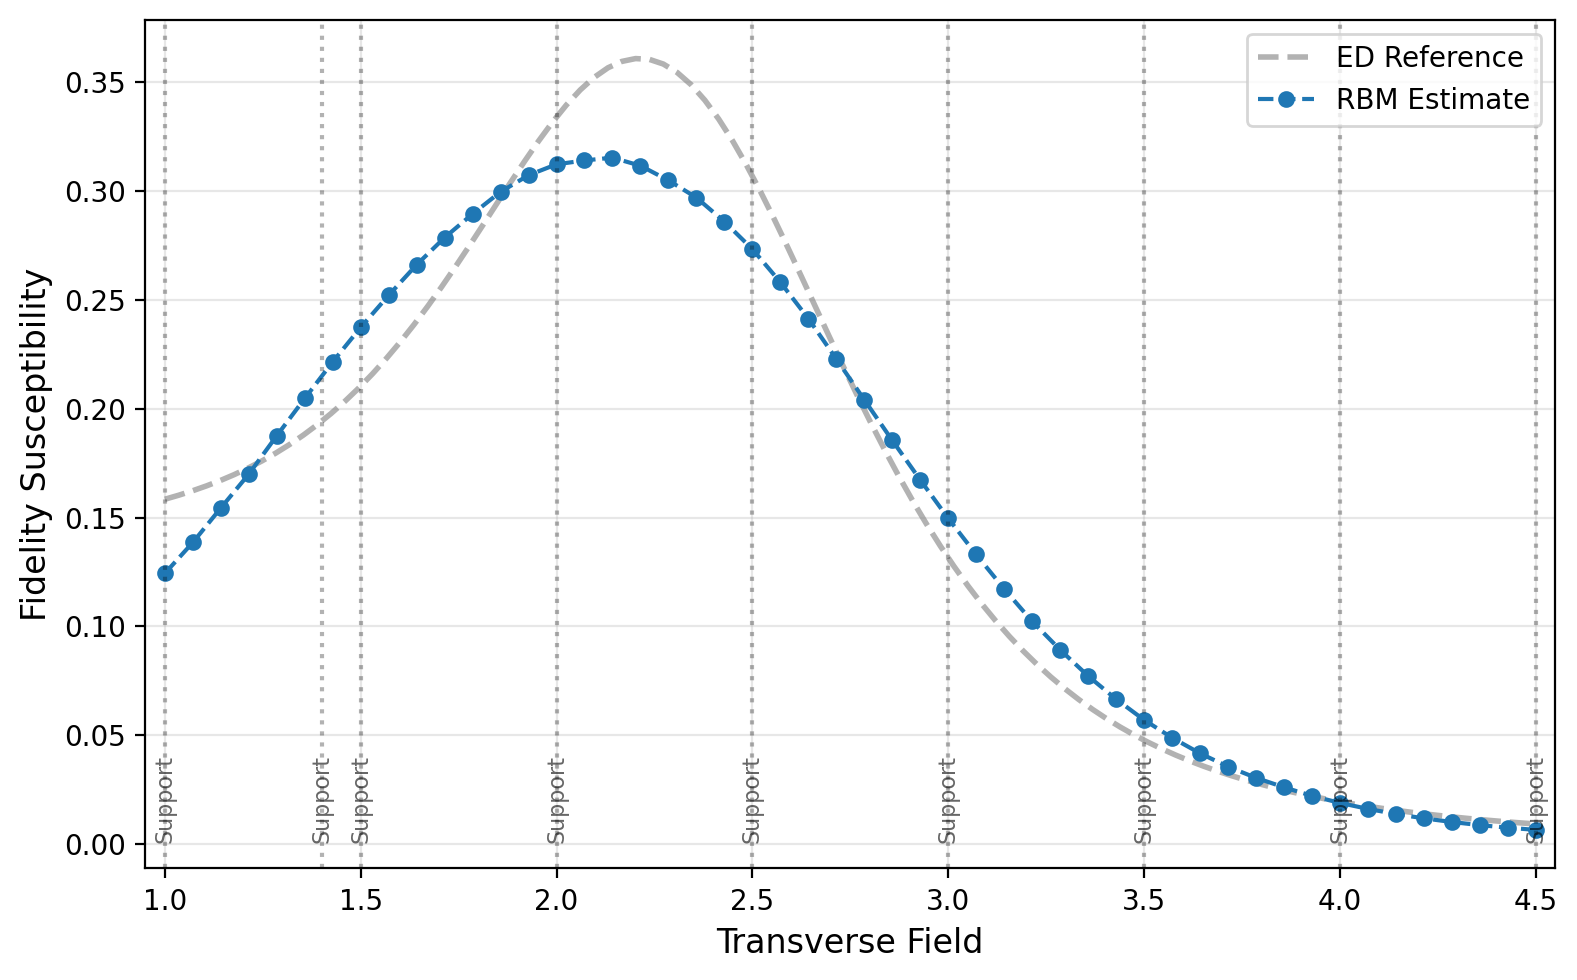

In [8]:
H_MIN = 1.0
H_MAX = 4.5
SWEEP_POINTS = 50
SAMPLES_EVAL = 100_000
K_STEPS_EVAL = 10

h_eval = np.linspace(H_MIN, H_MAX, SWEEP_POINTS)

print(f"Sweeping from h={H_MIN} to h={H_MAX} in {SWEEP_POINTS} steps with {SAMPLES_EVAL} Gibbs samples each...")

chi_values = []
for i, h in enumerate(h_eval):

    # instead of carrying over RNG state, we have Common Random Numbers (CRN)
    rng_point = torch.Generator(device=device).manual_seed(42)

    chi = estimate_susceptibility(model, h, n_samples=SAMPLES_EVAL, k_steps=K_STEPS_EVAL, rng=rng_point)
    chi_values.append(chi)

    if ((i + 1) % 10) == 0:
        print(f"h={h:.2f} | chi={chi:.4f}")


plt.figure(figsize=(8, 5), dpi=200)

plt.plot(ref_df["h"], ref_df["chi_F"], "--", color="gray", linewidth=2, alpha=0.6, label="ED Reference")
plt.plot(h_eval, chi_values, "o--", markersize=5, label="RBM Estimate")

for h_supp in h_support:
    if H_MIN <= h_supp <= H_MAX:
        plt.axvline(h_supp, linestyle=":", color="k", alpha=0.3)
        plt.text(h_supp, 0.03, "Support", rotation=90, va="bottom", ha="center",
                 fontsize=8, alpha=0.6, transform=plt.gca().get_xaxis_transform())

plt.xlabel(r"Transverse Field", fontsize=12)
plt.ylabel(r"Fidelity Susceptibility", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(H_MIN - 0.05, H_MAX + 0.05)
plt.tight_layout()
plt.show()

In [9]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
results = np.column_stack((h_eval, chi_values))

file_name = f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_suscept_rbm_{timestamp}.csv"
save_path = results_dir / file_name

header = "h,chi_F"
np.savetxt(save_path, results, delimiter=",", header=header, comments="")
print(f"Data saved to: {save_path}")

Data saved to: results/tfim_3x3_suscept_rbm_20260121_200947.csv


Evaluating overlap on 9 support points...
h=1.00 | Overlap = 0.99982
h=1.40 | Overlap = 0.99981
h=1.50 | Overlap = 0.99977
h=2.00 | Overlap = 0.99940
h=2.50 | Overlap = 0.99934
h=3.00 | Overlap = 0.99954
h=3.50 | Overlap = 0.99972
h=4.00 | Overlap = 0.99975
h=4.50 | Overlap = 0.99973


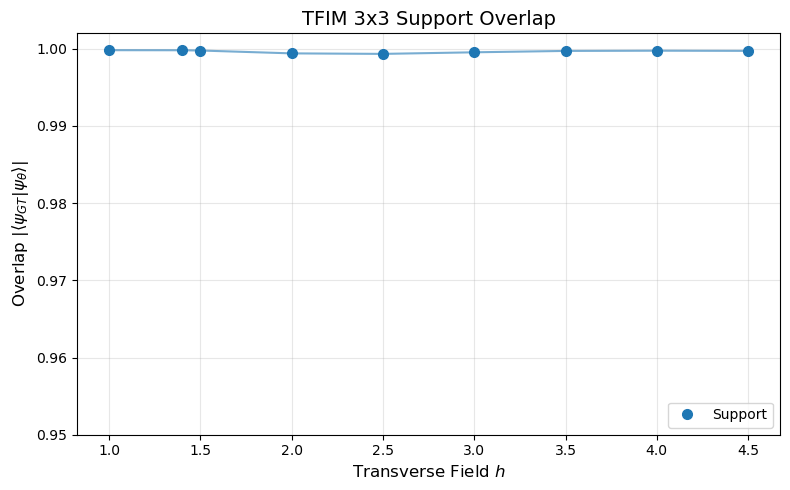

In [10]:
print(f"Evaluating overlap on {len(h_support)} support points...")

# Generate basis states once
all_states = generate_basis_states(model.num_v, device)

overlap_rows = []
for h_val in h_support:
    # Strictly assume file exists as requested
    gt_path = state_dir / f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{h_val:.2f}.npz"

    psi_true = load_gt_wavefunction(gt_path, device)
    overlap = calculate_exact_overlap(model, h_val, psi_true, all_states)

    overlap_rows.append({"h": float(h_val), "overlap": float(overlap)})
    print(f"h={h_val:.2f} | Overlap = {overlap:.5f}")

overlap_df = pd.DataFrame(overlap_rows)


plt.figure(figsize=(8, 5), dpi=100)
plt.plot(overlap_df["h"], overlap_df["overlap"], '-', color='tab:blue', alpha=0.6)
plt.plot(overlap_df["h"], overlap_df["overlap"], 'o', color='tab:blue', markersize=7, label="Support")

plt.xlabel(r"Transverse Field $h$", fontsize=12)
plt.ylabel(r"Overlap $|\langle \psi_{GT} | \psi_{\theta} \rangle|$", fontsize=12)
plt.title(f"TFIM {SIDE_LENGTH}x{SIDE_LENGTH} Support Overlap", fontsize=14)
plt.ylim(0.95, 1.002)
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [11]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
file_name = f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_support_overlap_{timestamp}.csv"
save_path = results_dir / file_name

overlap_df.to_csv(save_path, index=False)
print(f"Overlap data saved to: {save_path}")

Overlap data saved to: results/tfim_3x3_support_overlap_20260121_200952.csv
